Author: Eli Hecht
Purpose: adapt Alina's sentence embedding code to group decision-study responses

### Imports

In [1]:
import os

In [2]:
import pandas as pd

In [3]:
# Load the model

from sentence_transformers import SentenceTransformer #load the model
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')


/Users/elihecht/Desktop/BigPhil/scratch-code/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/elihecht/Desktop/BigPhil/scratch-code/.conda/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [4]:
import umap
from sklearn.cluster import KMeans
from scipy.spatial import distance_matrix

In [5]:
## filtering for personal words

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

In [38]:
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
# import kaleido
import plotly.io as pio
import matplotlib.pyplot as plt

### Define analysis functions

In [7]:
def make_directories(dir):
    if not os.path.exists(dir):
        os.mkdir(dir)
    if not os.path.exists(dir + 'plots/'):
        os.mkdir(dir + 'plots/')
    if not os.path.exists(dir + 'cluster_tables/'):
        os.mkdir(dir + 'cluster_tables/')

In [8]:
# A function to filter specified words and pronouns

def filter_words(sentence, words_to_remove):
    # Tokenize
    words = word_tokenize(sentence)
    
    # Tag each word with its part of speech
    pos_tags = nltk.pos_tag(words)
    
    #Define the pos tags for personal words
    pronoun_tags = {'PRP', 'PRP$'}
    
    words_to_remove_lower = [noun.lower() for noun in words_to_remove]

    #Filter out words that are personal words
    filtered_words = [word for word, tag in pos_tags if tag not in pronoun_tags and word.lower() not in words_to_remove_lower]
    
    #Reassemble the sentence
    return ' '.join(filtered_words)

In [9]:
# testing pronoun removal
filter_words('my name is Eli. I would go to the park', ["Eli", "would"])

'name is . go to the park'

In [10]:
# function to compute embeddings for a single vignette

def compute_embeddings(df, text_column, vignette_number, words_to_remove):
    options_df = df[df['context'] == vignette_number] 
    options_df = options_df.reset_index()

    # Convert all responses to strings
    options_df[text_column] = options_df[text_column].astype(str)

    # Delete proper name for clustering ease
    options_df[text_column] = options_df[text_column].apply(lambda x: filter_words(x, words_to_remove))

    options = options_df[text_column].tolist()
    options_embeddings = model.encode(options, show_progress_bar=True) # compute option embeddings
    return options_embeddings, options_df



In [11]:
# dimensionality reduction with pre-defined parameters
def compute_clusters(options_embeddings, clustering_params, umap_params):
    clustering_model = KMeans(n_clusters=clustering_params['num_clusters'], n_init='auto')
    umap_embeddings = (umap.UMAP(n_neighbors=umap_params['n_neighbors'], 
                                    n_components=umap_params['n_components'], 
                                    metric=umap_params['metric'],
                                    min_dist=umap_params['min_dist'],
                                    random_state=umap_params['random_state'])
                                .fit_transform(options_embeddings))
    
    # perform KMeans clustering and look at clusters 
    clustering_model.fit(umap_embeddings)
    return umap_embeddings, clustering_model.labels_, clustering_model



In [12]:
def print_clusters(options_df, text_column_name, cluster_assignment, numb_clusters):
    clustered_sentences = [[] for i in range(numb_clusters)]
    for sentence_id, cluster_id in enumerate(cluster_assignment):
        clustered_sentences[cluster_id].append(options_df[text_column_name][sentence_id])

    for i, cluster in enumerate(clustered_sentences):
        print("Cluster ", i+1)
        cluster_list = []
        for item in cluster:
            # removes identical context that is included in text of each result
            cluster_list.append(item.split(":", 1)[-1].strip())
        print(cluster_list)
        print("")

In [35]:
def k_plot(options_embeddings, umap_params, directory):
    distortions = []
    K_range = range(1, 18)


    umap_embeddings = (umap.UMAP(n_neighbors=umap_params['n_neighbors'], 
                                        n_components=umap_params['n_components'], 
                                        metric=umap_params['metric'],
                                        min_dist=umap_params['min_dist'],
                                        random_state=umap_params['random_state'])
                                    .fit_transform(options_embeddings))
    
    # perform KMeans clustering and look at clusters 
    for k in K_range:
        # print("k:" + str(k))
        clustering_model = KMeans(n_clusters=k, n_init='auto')
        clustering_model.fit(umap_embeddings)
        distortions.append(clustering_model.inertia_)

    # Plotting the elbow curve
    plt.plot(K_range, distortions, marker='o')
    plt.title('Elbow Method For Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Sum of Squared Distances')
    plt.savefig(directory)
    plt.show()

In [14]:
# create a df with clusters, centroids and umap embeddings
def compute_centroid(options_df, text_column_name, cluster_assignment, clustering_model, umap_embeddings):
    # attach the cluster assignments to the dataframe
    options_df['cluster'] = pd.Series(cluster_assignment, index=options_df.index)

    # Attach the centroids to the dataframe
    # In sklearn, the cluster centers are available directly via clustering_model.cluster_centers_
    options_df['centroid'] = options_df['cluster'].apply(lambda x: clustering_model.cluster_centers_[x])

    # Split the UMAP embeddings into individual columns for easier processing later
    for i in range(umap_embeddings.shape[1]):
        options_df[f'umap_dim_{i}'] = umap_embeddings[:, i]

    # Convert the UMAP embeddings from individual columns to lists for use in the distance calculation
    umap_list = [f'umap_dim_{i}' for i in range(umap_embeddings.shape[1])]
    options_df['umap_embedding_list'] = options_df[umap_list].apply(lambda row: row.tolist(), axis=1)

    # Define a function to compute the distance of each embedding from its cluster's centroid
    def distance_from_centroid(row):
        return distance_matrix([row['umap_embedding_list']], [row['centroid']])[0][0]
    options_df['distance_from_centroid'] = options_df.apply(distance_from_centroid, axis=1)

    # Select the 'response' closest to each cluster centroid to serve as a summary of the cluster
    summary = options_df.sort_values('distance_from_centroid', ascending=True).groupby('cluster').head(1).sort_index()[text_column_name].tolist()

    # Create a dictionary linking each summary 'response' to its corresponding cluster number
    clusters = {}
    for i in range(len(summary)):
        clusters[summary[i]] = options_df.loc[options_df[text_column_name] == summary[i], "cluster"].iloc[0]

    return clusters

In [15]:
def umap_2(options_df, options_embeddings, clusters, umap_params):
    # umaps to 2 dimensions for plotting
    umap_embeddings_2 = (umap.UMAP(n_neighbors=umap_params['n_neighbors'], 
                                    n_components=2, 
                                    metric=umap_params['metric'],
                                    min_dist=umap_params['min_dist'],
                                    random_state=umap_params['random_state'])
                                .fit_transform(options_embeddings))
    for i in range(umap_embeddings_2.shape[1]):
        options_df[f'umap_dim2_{i}'] = umap_embeddings_2[:, i]

    # create a dictionary with cluster numbers as keys and their centroid options as values
    id_to_name = {v: k for k, v in clusters.items()}

    options_df['cluster_name'] = options_df['cluster'].map(id_to_name) # create a column with centroid options

    options_df['cluster_name'] = options_df['cluster_name'].apply(lambda x: x.split(":", 1)[-1].strip())

In [16]:
# Function to plot clusters on the joint embedding space


# def normalize(values):
#     min_val = np.min(values)
#     max_val = np.max(values)
#     if max_val - min_val == 0:  # Avoid division by zero if all values are the same
#         return np.ones_like(values)
#     return (values - min_val) / (max_val - min_val)
# 3:15

def plot_clusters(component1, component2, cluster, name, response,
                   data_source, 
                   umap_params, clustering_params,
                   plot_location):
    pio.renderers.default = "browser"
    color_palette = px.colors.qualitative.Light24
    
    fig = go.Figure()
    
    title_str = f"UMAP Parameters: n_neighbors={umap_params['n_neighbors']}, n_components={umap_params['n_components']}, min_dist={umap_params['min_dist']} | Clustering: {clustering_params['algorithm_name']} with k={clustering_params['num_clusters']} clusters"
    
    # Get unique clusters and data sources
    unique_clusters = sorted(cluster.unique())
    unique_data_sources = sorted(data_source.unique())

    color_map = {uc: color_palette[i % len(color_palette)] for i, uc in enumerate(unique_clusters)}
    marker_symbols = {
        unique_data_sources[1]: 'square',
        unique_data_sources[0]: 'diamond'
    }
    
    # # Define colors for each trajectory
    # trajectory_colors = {
    #     unique_data_sources[0]: 'red',
    #     unique_data_sources[1]: 'blue'
    # }
    
    # Add a trace for each Source to indicate the shape in the legend
    for ds, symbol in marker_symbols.items():
        fig.add_trace(go.Scatter(
            x=[None],
            y=[None],
            mode='markers',
            marker=dict(
                size=10,
                symbol=symbol,
                color=trajectory_colors[ds]
            ),
            name=f'{ds.capitalize()} (shape and trajectory)'
        ))

    added_cluster_names = set()
    for ds in unique_data_sources:
        for uc in unique_clusters:
            mask = (cluster == uc) & (data_source == ds)
            if mask.any():  # Check if there are any rows after applying the mask
                # normalized_opacities = 1 - normalize(gen_num[mask])
                # opacity_values = 0.2 + 0.8 * normalized_opacities
                # opacity_values = np.nan_to_num(opacity_values) 
                show_in_legend = name[mask].iloc[0] not in added_cluster_names
                # show_in_legend = False
                added_cluster_names.add(name[mask].iloc[0])
                
                fig.add_trace(go.Scatter(
                    x=component1[mask],
                    y=component2[mask],
                    mode='text+markers',
                    name=name[mask].iloc[0] if show_in_legend else None,
                    legendgroup=f'group{uc}',
                    showlegend=show_in_legend,
                    hovertext= str(uc) + ": " + response[mask] ,
                    # text='gen_num[mask].astype(str)',
                    marker=dict(
                        size=12,
                        color=color_map[uc],
                        symbol=marker_symbols[ds],  # Use the marker symbol based on the data source
                        line_width=1,
                        opacity=1
                    ),
                    textfont=dict(
                        size=10,
                        color='black'
                    )
                ))


    fig.update_layout(
        margin=dict(l=100, r=100, b=100, t=100),
        width=2000,
        height=1200,
        showlegend=False,
        title=title_str,
        paper_bgcolor='white',  # White background for the entire plot area
        plot_bgcolor='white',
        legend=dict(
            yanchor="top",
            y=1,
            xanchor="left",
            x=0.01,
            bgcolor='rgba(255,255,255,0)'
        )
    )

    fig.layout.template = 'ggplot2'
    fig.write_html(plot_location)

### Load in data

In [17]:
agent_list = ['Heinz', 'Josh', 'Brian', 'Liz', 'Mary', 'Brad', 'Darya', 'Eunice', 'Eamon', 'Cameron', 'Erica', 'Carl', 'Daniel', 'Andy', 'Ahmed', 'Eva', 'Jeff', 'Shania']

In [18]:
df_decision = pd.read_csv('../data/decision.csv')

# add id column
df_decision = df_decision.reset_index().rename(columns={'index': 'id'})
df_decision['id'] += 1

# select only participants who finished
df_decision = df_decision[df_decision['finished']]

# exclude ids of participants who gave non-sensical responses
exclude_ids = [21, 64, 72, 74, 84, 86, 89]
df_decision[~df_decision['id'].isin(exclude_ids)].reset_index(drop=True) 

# Select columns 'id', 'S1_1' to 'S18_1'
df_decision = df_decision[['id', 'S1_1', 'S2_1', 'S3_1', 'S4_1', 'S5_1', 'S6_1', 'S7_1', 'S8_1', 'S9_1', 'S10_1', 'S11_1', 'S12_1', 'S13_1', 'S14_1', 'S15_1', 'S16_1', 'S17_1', 'S18_1']]

#  Melt the DataFrame to long format
df_decision = pd.melt(df_decision, id_vars=['id'], var_name='context', value_name='decision')

# Extract numeric values from 'context' column using str.extract
df_decision['context'] = df_decision['context'].str.extract('(\d+)').astype(int)


df_decision.dropna(subset=['decision'], inplace=True)
df_decision.rename(columns={'decision': 'response'}, inplace=True)

# add source column
df_decision['source'] = 'decision'

# df_decision

In [19]:
df_pg = pd.read_csv('../manualCoding/pg_coded_final.csv', index_col=0)
df_pg = df_pg[['context', 'id', 'answer', 'text', 'value']]
df_pg.rename(columns={"text":"response"}, inplace=True)
df_pg['source'] = 'pg'

In [21]:
# Merge decision study data and possibility generation study data into one data frame for clustering
df = pd.merge(df_decision, df_pg, how='outer')

In [22]:
# Add full scenario texts to merged_text to give LLM context for responses
contexts_list = pd.read_csv('../materials/contextsTable.csv', index_col=0)['text']

df_merge = pd.merge(df, contexts_list, left_on='context', right_index=True)
df_merge['merged_text'] = df_merge['text'] + ' : ' + df_merge['response']
df_merge.rename(columns={"response": "response_original", "text": "scenario_text"}, inplace=True)

df = df_merge

In [23]:
df

,id,context,response_original,source,answer,value,scenario_text,merged_text
0,1,1,look for coupon,decision,NaN,NaN,Heinz’s wife has recently fallen ill and needs...,Heinz’s wife has recently fallen ill and needs...
1,2,1,I ask my friends for help with this medication.,decision,NaN,NaN,Heinz’s wife has recently fallen ill and needs...,Heinz’s wife has recently fallen ill and needs...
2,3,1,Get a side hustle to make some more money.,decision,NaN,NaN,Heinz’s wife has recently fallen ill and needs...,Heinz’s wife has recently fallen ill and needs...
3,4,1,buy it for them,decision,NaN,NaN,Heinz’s wife has recently fallen ill and needs...,Heinz’s wife has recently fallen ill and needs...
4,5,1,Ask friends and family for help while working ...,decision,NaN,NaN,Heinz’s wife has recently fallen ill and needs...,Heinz’s wife has recently fallen ill and needs...
...,...,...,...,...,...,...,...,...
10775,237,18,laugh,pg,5.0,4.666667,Shania is competing in a 100-mile dogsledding ...,Shania is competing in a 100-mile dogsledding ...
10776,243,18,Ask what can be done,pg,5.0,100.000000,Shania is competing in a 100-mile dogsledding ...,Shania is competing in a 100-mile dogsledding ...
10777,253,18,Laugh as she went by the other competitor,pg,5.0,0.000000,Shania is competing in a 100-mile dogsledding ...,Shania is competing in a 100-mile dogsledding ...
10778,289,18,Say a quick prayer for her competitor and then...,pg,5.0,9.000000,Shania is competing in a 100-mile dogsledding ...,Shania is competing in a 100-mile dogsledding ...


In [116]:
# num of groups used for manual coding each scenario
num_manual_groups_by_scenario = [14, 16, 15, 16, 14, 15, 13, 15, 16, 14, 15, 17, 17, 18, 17, 14, 14, 14]

### Run functions on one scenario
Allows you to work through the analysis for a single scenario block by block

In [43]:
# Edit the values in this cell then run this cell and all below

scenario_number = 13

# text_column_name options: 'response_original' or 'merged_text'
# merged_text gives context by merging response with the scenario text and gives better results
text_column_name = 'merged_text'

# clusters_from options: 'elbow_results', 'same_as_manual', 'fixed'
# 'elbow_results' use the number of clusters for each context based on the results of the elbow plots (code below)
# 'same_as_manual' uses the same number of clusters for each context as was determine via manual coding for fair comparison between the two
# 'fixed' allows you to directly set the number of clusters
clusters_from = 'same_as_manual'

if clusters_from == 'fixed':
    # Modify this if fixing the number of clusters
    numb_clusters = 11

# directory to place resulting plots and table with cluster groupings
dir = "elbow2/"

# Define UMAP and clustering parameters
umap_params = {'n_neighbors': 100, 'n_components': 10, 'metric': 'cosine', 'min_dist': 0.05, 'random_state': None}


In [44]:
# check that directory exists and make it if it doesn't
make_directories(dir)

In [45]:
# select appropriate agent name based on scenario number
agent_name = agent_list[scenario_number-1]

In [46]:
words_to_remove = [agent_name, 'should', 'would', 'could']

# strip each response and compute the SBERT embeddings for each
options_embeddings, options_df = compute_embeddings(df, text_column_name, scenario_number, words_to_remove)

Batches: 100%|██████████| 19/19 [00:04<00:00,  4.03it/s]


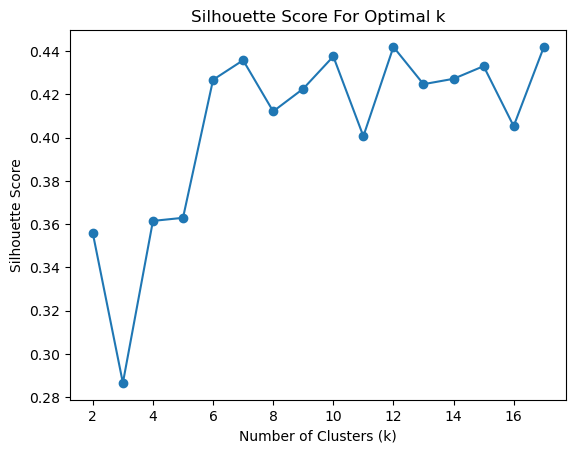

In [51]:
from sklearn.metrics import silhouette_score

# Assuming X is your data
silhouette_scores = []

K_range = range(2, 18)

umap_embeddings = (umap.UMAP(n_neighbors=umap_params['n_neighbors'], 
                                n_components=umap_params['n_components'], 
                                metric=umap_params['metric'],
                                min_dist=umap_params['min_dist'],
                                random_state=umap_params['random_state'])
                            .fit_transform(options_embeddings))
for k in K_range:
    # print("k:" + str(k))
    kmeans = KMeans(n_clusters=k, n_init='auto')
    kmeans.fit(umap_embeddings)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(umap_embeddings, labels)
    silhouette_scores.append(silhouette_avg)
    

# Plotting silhouette scores
plt.plot(K_range, silhouette_scores, marker='o')
plt.title('Silhouette Score For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

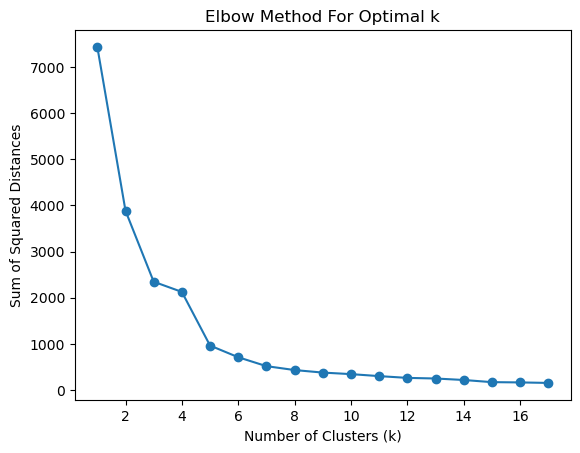

In [40]:
k_plot(options_embeddings, umap_params, dir + 'elbow_plots/S' + str(scenario_number) + '.png')

In [ ]:

# # elbow curve plots for determining appropriate number of clusters
# if clusters_from == 'elbow_results':
#     k_plot(options_embeddings, umap_params, dir + 'elbow_plots/S' + str(scenario_number) + '.png')



In [35]:
# if(clusters_from == "elbow_results"):
    
#     numb_clusters = elbow_results[scenario_number]


In [75]:
# select appropriate number of clusters if the clusters are coming from manual groups
if clusters_from == 'same_as_manual':
    # + 1 is added to above number because some options were manually coded as 'other', giving one more category than the stated number
    numb_clusters = num_manual_groups_by_scenario[scenario_number-1]+1

In [83]:

# define clustering params based on numb_clusters defined above
clustering_params = {'algorithm_name': 'KMeans', 'num_clusters': numb_clusters}

# Compute clusters of responses using KMeans
umap_embeddings, cluster_assignment, clustering_model = compute_clusters(options_embeddings, clustering_params, umap_params)

In [84]:
print_clusters(options_df, text_column_name, cluster_assignment, numb_clusters)

Cluster  1
['call a friend', 'will call a friend', 'call tripple A', 'call a friend', 'Call a friend', 'Call a friend', 'Call a friend', 'call a friend for aride', 'call friend', 'call friends', 'call friend', 'Call a friend', 'call friend', 'Call a friend', 'call friend/relatives', 'Call a friend', 'coult phone a friend .', 'call friends', 'call a friend', 'call upon friends', 'call a friend']

Cluster  2
['Call a tow truck and an uber and have both ready to pick up the car and .', 'Call a tow truck and an Uber . Have the car towed to a trusted mechanic and continue to trip .', 'Leave the car and call an uber . while in the uber call a relative and tell to take care of the car .', 'call uber , tow truck', 'call to have car towed back to house , uber to airport .', 'call a towing company and police and let know . call an uber to get to the airport', "Call a tow service and also call an Uber ; 'll have to take care of car when get back , but need to get to this trip !", 'call a tow truc

In [85]:
# create a df with clusters, centroids and umap embeddings
clusters = compute_centroid(options_df, text_column_name, cluster_assignment, clustering_model, umap_embeddings)

In [86]:
# reduce dimensionality to two for plotting
umap_2(options_df, options_embeddings, clusters, umap_params)

In [87]:
options_df

,index,id,context,response_original,source,answer,value,scenario_text,merged_text,cluster,...,umap_dim_5,umap_dim_6,umap_dim_7,umap_dim_8,umap_dim_9,umap_embedding_list,distance_from_centroid,umap_dim2_0,umap_dim2_1,cluster_name
0,100,0,2,Call someone to help,decision,NaN,NaN,Josh is on the way to the airport to catch a f...,is on the way to the airport to catch a flight...,7,...,3.664594,0.662423,6.980509,9.084754,1.378183,"[2.1551315784454346, 6.679914474487305, 8.2658...",0.570027,7.321781,10.414286,call for help
1,101,1,2,I would call a towtruck to tow my car to the a...,decision,NaN,NaN,Josh is on the way to the airport to catch a f...,is on the way to the airport to catch a flight...,4,...,2.848299,0.893593,6.664720,9.591381,-0.139677,"[1.1085277795791626, 8.971457481384277, 5.7148...",0.258632,3.555548,13.827587,"call a tow truck and , pay in advance , and se..."
2,102,2,2,Push the car out of the way and start dealing ...,decision,NaN,NaN,Josh is on the way to the airport to catch a f...,is on the way to the airport to catch a flight...,16,...,4.084637,0.163276,7.059867,8.868261,0.999164,"[1.0513200759887695, 7.298147201538086, 8.0030...",0.252974,5.770655,9.774565,try to fix the car
3,103,3,2,just continue my way there,decision,NaN,NaN,Josh is on the way to the airport to catch a f...,is on the way to the airport to catch a flight...,12,...,5.056378,0.026082,7.353536,8.514551,0.815240,"[0.7514459490776062, 6.664596080780029, 8.1416...",0.546456,5.661519,7.831890,walk to the airport .
4,104,4,2,Call a tow truck to take me to airport parking.,decision,NaN,NaN,Josh is on the way to the airport to catch a f...,is on the way to the airport to catch a flight...,4,...,3.050959,1.057423,6.622959,9.542545,-0.161109,"[1.0477831363677979, 9.008235931396484, 5.7060...",0.330400,3.450387,13.830501,"call a tow truck and , pay in advance , and se..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600,10359,45,2,sleep,pg,5.0,33.333333,Josh is on the way to the airport to catch a f...,is on the way to the airport to catch a flight...,2,...,4.475980,0.245576,7.596276,8.797661,1.258023,"[1.3240748643875122, 6.6430792808532715, 8.462...",0.519908,6.890068,8.495632,will miss flight and go home .
601,10360,70,2,don't worry about and just try to get there wh...,pg,5.0,46.666667,Josh is on the way to the airport to catch a f...,is on the way to the airport to catch a flight...,2,...,4.327417,0.170966,7.455458,8.769227,1.310259,"[1.2116377353668213, 6.7638468742370605, 8.501...",0.630293,6.810497,8.769642,will miss flight and go home .
602,10361,78,2,cry,pg,5.0,83.333333,Josh is on the way to the airport to catch a f...,is on the way to the airport to catch a flight...,7,...,4.039360,0.353192,7.268762,8.896570,1.469830,"[1.6553057432174683, 6.639359474182129, 8.5118...",0.564782,7.073092,9.346825,call for help
603,10362,85,2,cry.,pg,5.0,44.000000,Josh is on the way to the airport to catch a f...,is on the way to the airport to catch a flight...,7,...,4.099432,0.297240,7.266083,8.854703,1.429718,"[1.5585459470748901, 6.653404712677002, 8.4950...",0.636614,7.087283,9.277257,call for help


In [88]:
# save options_df for this scenario to cluster_tables
options_df.to_csv(f'{dir}cluster_tables/S{scenario_number}.csv')

In [89]:
# Call your function with the appropriate DataFrame columns
plot_clusters(
    options_df['umap_dim2_0'],
    options_df['umap_dim2_1'],
    options_df['cluster'],
    # options_df["generation_number"],
    options_df["cluster_name"],
    options_df["response_original"],
    options_df["source"],
    umap_params,
    clustering_params,
    # id_gpt3=54,
    # id_human=36,
    dir + 'plots/S' + str(scenario_number) + '.html'
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### Create elbow plots to determine appropriate number of clusters per context

Running analysis on scenario 1


Batches: 100%|██████████| 19/19 [00:04<00:00,  3.87it/s]


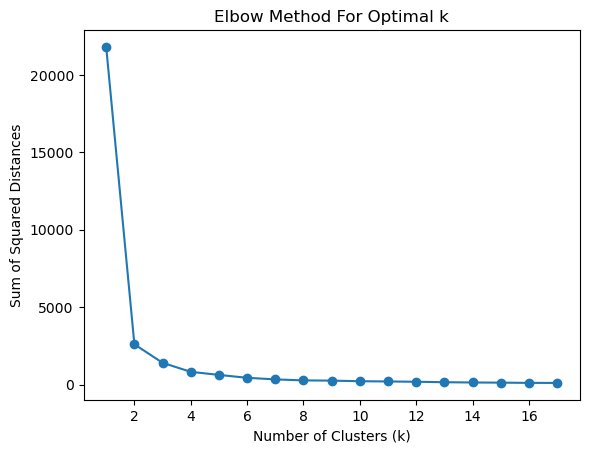

Running analysis on scenario 2


Batches: 100%|██████████| 19/19 [00:05<00:00,  3.32it/s]


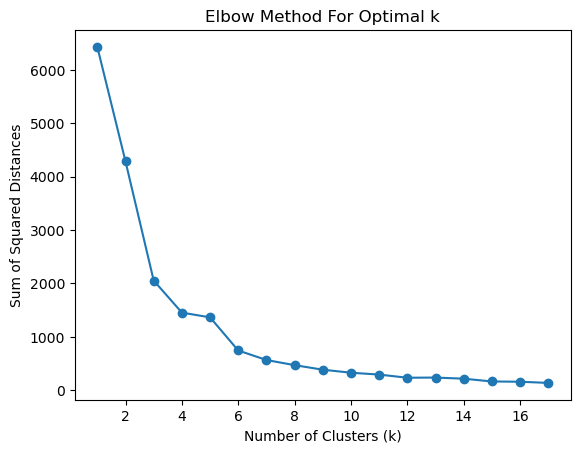

Running analysis on scenario 3


Batches: 100%|██████████| 19/19 [00:05<00:00,  3.54it/s]


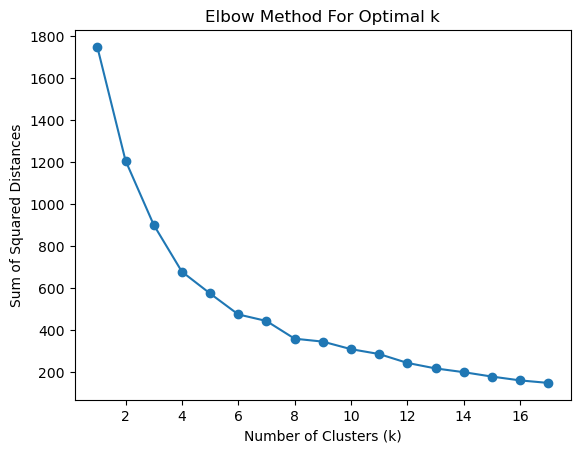

Running analysis on scenario 4


Batches: 100%|██████████| 19/19 [00:05<00:00,  3.64it/s]


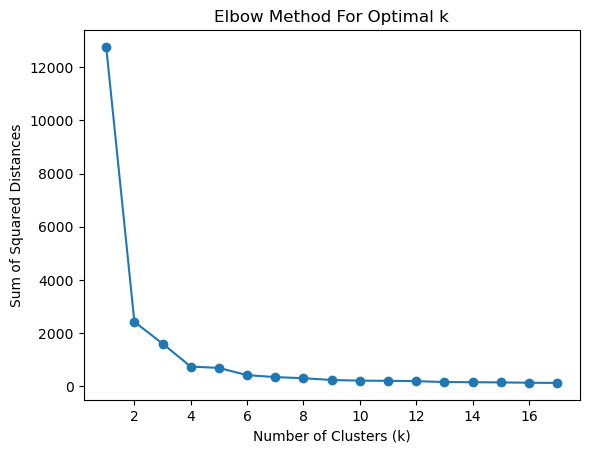

Running analysis on scenario 5


Batches: 100%|██████████| 19/19 [00:04<00:00,  3.97it/s]


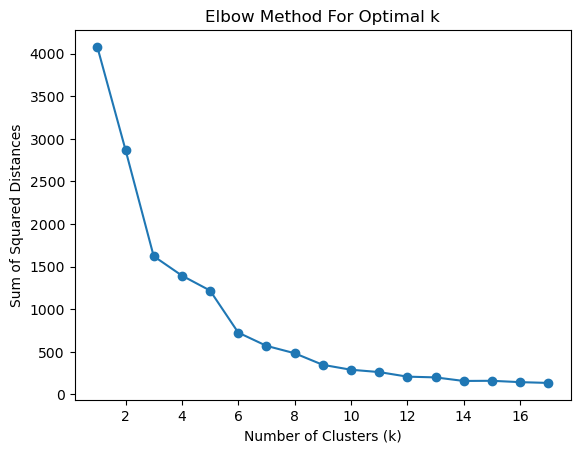

Running analysis on scenario 6


Batches: 100%|██████████| 19/19 [00:04<00:00,  3.99it/s]


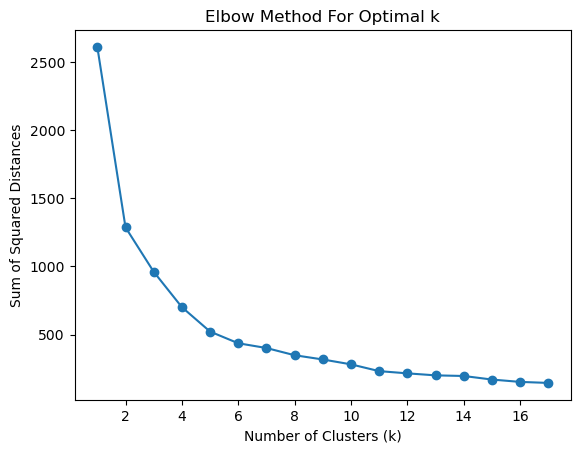

Running analysis on scenario 7


Batches: 100%|██████████| 19/19 [00:04<00:00,  4.38it/s]


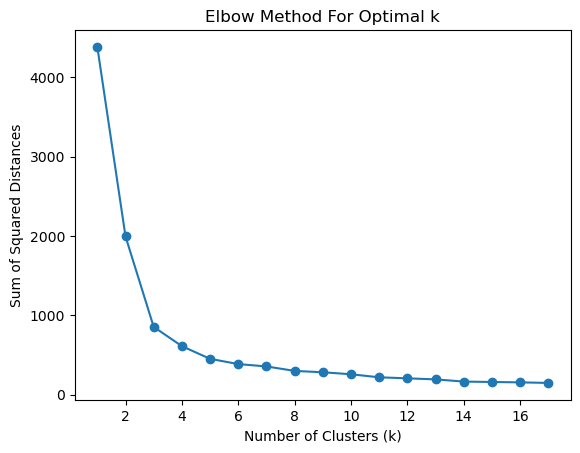

Running analysis on scenario 8


Batches: 100%|██████████| 19/19 [00:07<00:00,  2.57it/s]


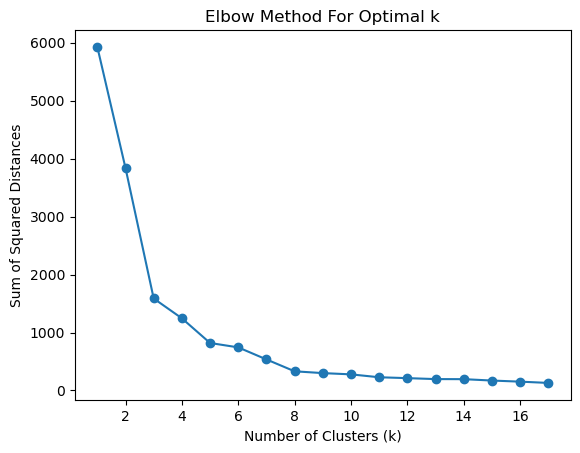

Running analysis on scenario 9


Batches: 100%|██████████| 19/19 [00:06<00:00,  2.77it/s]


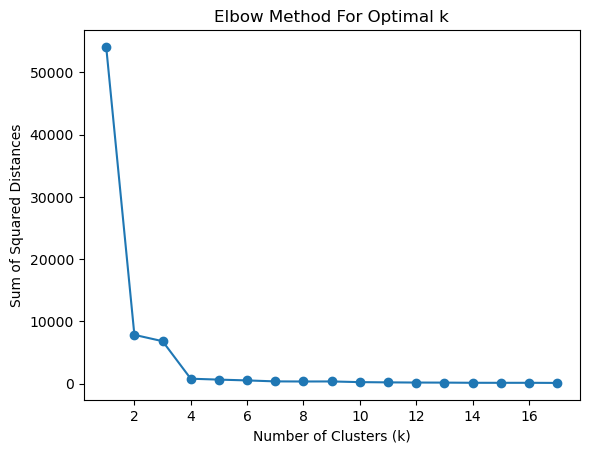

Running analysis on scenario 10


Batches: 100%|██████████| 19/19 [00:06<00:00,  2.92it/s]


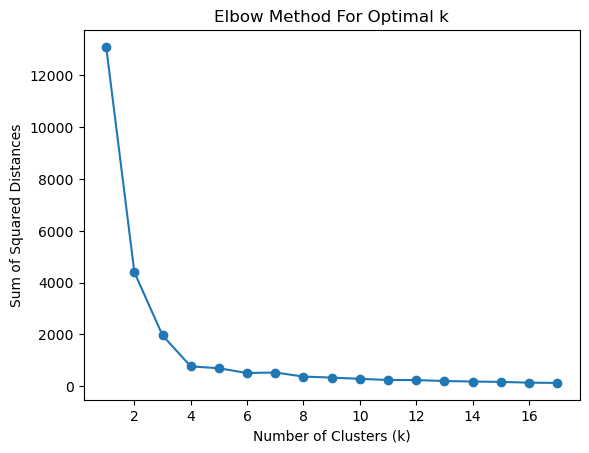

Running analysis on scenario 11


Batches: 100%|██████████| 19/19 [00:05<00:00,  3.74it/s]


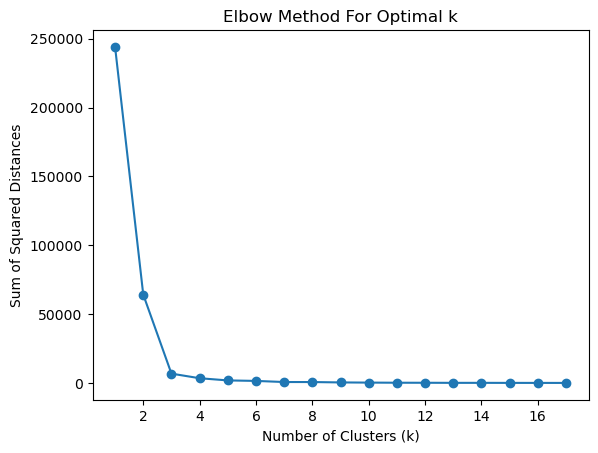

Running analysis on scenario 12


Batches: 100%|██████████| 19/19 [00:04<00:00,  4.51it/s]


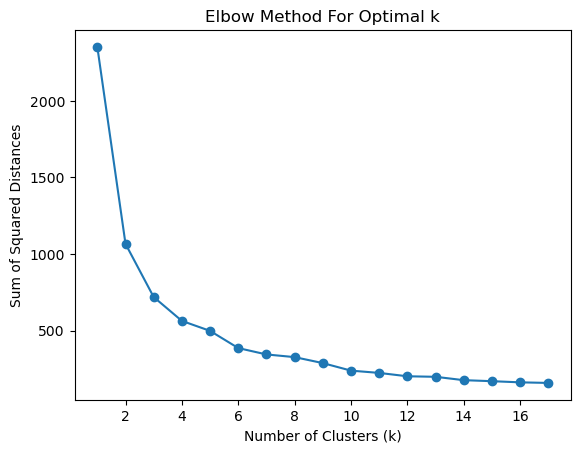

Running analysis on scenario 13


Batches: 100%|██████████| 19/19 [00:04<00:00,  4.09it/s]


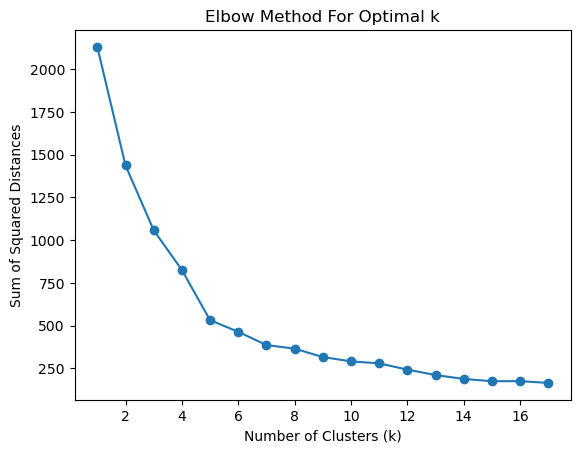

Running analysis on scenario 14


Batches: 100%|██████████| 19/19 [00:04<00:00,  4.06it/s]


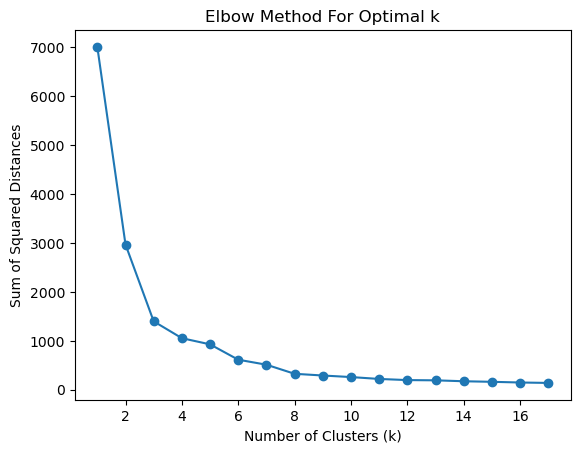

Running analysis on scenario 15


Batches: 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]


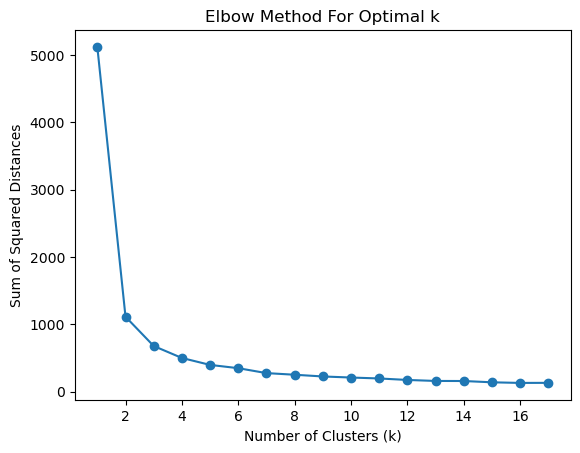

Running analysis on scenario 16


Batches: 100%|██████████| 19/19 [00:08<00:00,  2.17it/s]


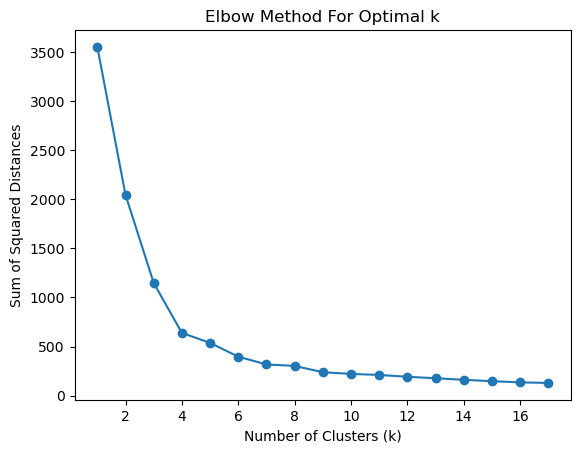

Running analysis on scenario 17


Batches: 100%|██████████| 19/19 [00:08<00:00,  2.14it/s]


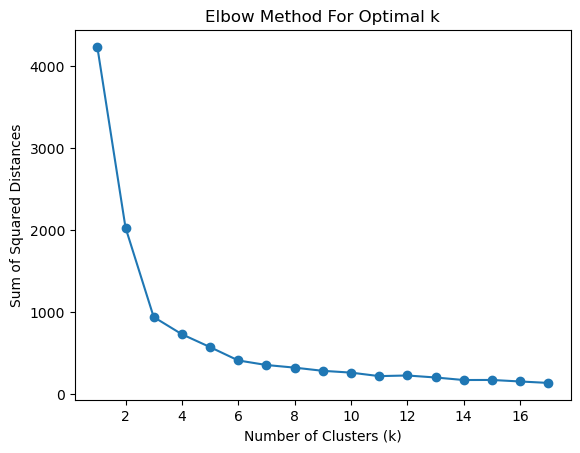

Running analysis on scenario 18


Batches: 100%|██████████| 19/19 [00:05<00:00,  3.27it/s]


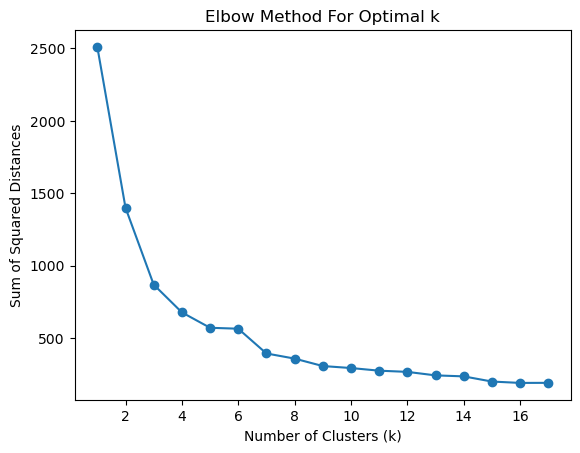

In [92]:
# text_column_name options: 'response_original' or 'merged_text'
# merged_text gives context by merging response with the scenario text and is preferred
text_column_name = 'merged_text'


# directory to place resulting plots and clusters
dir = "numFromElbow/"

# check that path exists and make it if it doesn't
if not os.path.exists(dir + 'elbow_plots/'):
    if not os.path.exists(dir):
            os.mkdir(dir)
    os.mkdir(dir + 'elbow_plots/')

# Define UMAP and clustering parameters
umap_params = {'n_neighbors': 100, 'n_components': 10, 'metric': 'cosine', 'min_dist': 0.05, 'random_state': None}

# creates plots and cluster_tables for each scenario
for scenario_number in range(1, 19):
    print("Running analysis on scenario " + str(scenario_number))
    # selects appropriate agent name based on scenario number
    agent_name = agent_list[scenario_number-1]
    words_to_remove = [agent_name, 'should', 'would', 'could']

    options_embeddings, options_df = compute_embeddings(df, text_column_name, scenario_number, words_to_remove)

    # elbow curve plots for determining appropriate number of clusters
    k_plot(options_embeddings, umap_params, f'{dir}elbow_plots/S{str(scenario_number)}.png')

In [94]:
# good number of clusters for each cluster using the results from the elbow plot
elbow_results = {
        1: 4, # 6?
        2: 6, 
        3: 8, # 
        4: 6, # 7?
        5: 6,
        6: 6,
        7: 6,
        8: 8,
        9: 4,
        10: 4,
        11: 3,
        12: 10,
        13: 7,
        14: 8, # 3?
        15: 7,
        16: 9, # 5?
        17: 6, # 6?
        18: 7
    }

### Run all scenarios in loop

In [117]:
# Edit the values in this cell then run this cell and the one below

# directory to send resulting plots and clusters
dir = "numSameAsManual2/"

# text_column_name options: 'response_original' or 'merged_text'
# merged_text gives context by merging response with the scenario text and generally gives better results
text_column_name = 'merged_text'

# clusters_from options: 'elbow_results', 'same_as_manual', 'fixed'
# 'elbow_results' use the number of clusters for each context based on the results of the elbow plots (code below)
# 'same_as_manual' uses the same number of clusters for each context as was determine via manual coding for fair comparison between the two
# 'fixed' allows you to directly set the number of clusters
clusters_from = 'same_as_manual'

if clusters_from == 'fixed':
    # Modify this if fixing the number of clusters
    numb_clusters = 11

# Define UMAP and clustering parameters
umap_params = {'n_neighbors': 100, 'n_components': 10, 'metric': 'cosine', 'min_dist': 0.05, 'random_state': None}

In [118]:
# check that path exists and make it if it doesn't
make_directories(dir)

# creates plots and cluster_tables for each scenario
for scenario_number in range(1, 19):
    print("Running analysis on scenario " + str(scenario_number))
    # selects appropriate agent name based on scenario number
    agent_list = ['Heinz', 'Josh', 'Brian', 'Liz', 'Mary', 'Brad', 'Darya', 'Eunice', 'Eamon', 'Cameron', 'Erica', 'Carl', 'Daniel', 'Andy', 'Ahmed', 'Eva', 'Jeff', 'Shania']
    agent_name = agent_list[scenario_number-1]


    words_to_remove = [agent_name, 'should', 'would', 'could']

    # Strip each response of words_to_remove and compute SBERT embeddings
    options_embeddings, options_df = compute_embeddings(df, text_column_name, scenario_number, words_to_remove)


    if(clusters_from == "elbow_results"):
        numb_clusters = elbow_results[scenario_number]

    # select appropriate number of clusters if the clusters are coming from 
    if clusters_from == 'same_as_manual':
        # + 1 is added to above number because some options were manually coded as 'other', giving one more category than the stated number
        numb_clusters = num_manual_groups_by_scenario[scenario_number-1]+1

    # define clustering params based on numb_clusters defined above
    clustering_params = {'algorithm_name': 'KMeans', 'num_clusters': numb_clusters}
    
    # compute clusters on embedded 
    umap_embeddings, cluster_assignment, clustering_model = compute_clusters(options_embeddings, clustering_params, umap_params)


    # print_clusters(options_df, text_column_name, cluster_assignment, numb_clusters)

    # create a df with clusters, centroids and umap embeddings
    clusters = compute_centroid(options_df, text_column_name, cluster_assignment, clustering_model, umap_embeddings)
    # reduce dimensionality to two for plotting
    umap_2(options_df, options_embeddings, clusters, umap_params)

    # options_df


    # save options_df for this scenario to cluster_tables
    options_df.to_csv(dir + 'cluster_tables/S' + str(scenario_number) + '.csv')
    # Call your function with the appropriate DataFrame columns
    plot_clusters(
        options_df['umap_dim2_0'],
        options_df['umap_dim2_1'],
        options_df['cluster'],
        # options_df["generation_number"],
        options_df["cluster_name"],
        options_df["response_original"],
        options_df["source"],
        umap_params,
        clustering_params,
        # id_gpt3=54,
        # id_human=36,
        f'{dir}plots/S{scenario_number}.html'
    )

Running analysis on scenario 1


Batches: 100%|██████████| 19/19 [00:04<00:00,  3.88it/s]


Running analysis on scenario 2


Batches: 100%|██████████| 19/19 [00:05<00:00,  3.38it/s]


Running analysis on scenario 3


Batches: 100%|██████████| 19/19 [00:05<00:00,  3.50it/s]


Running analysis on scenario 4


Batches: 100%|██████████| 19/19 [00:04<00:00,  3.81it/s]


Running analysis on scenario 5


Batches: 100%|██████████| 19/19 [00:04<00:00,  4.22it/s]


Running analysis on scenario 6


Batches: 100%|██████████| 19/19 [00:04<00:00,  4.22it/s]


Running analysis on scenario 7


Batches: 100%|██████████| 19/19 [00:03<00:00,  4.81it/s]


Running analysis on scenario 8


Batches: 100%|██████████| 19/19 [00:04<00:00,  4.37it/s]


Running analysis on scenario 9


Batches: 100%|██████████| 19/19 [00:03<00:00,  5.20it/s]


Running analysis on scenario 10


Batches: 100%|██████████| 19/19 [00:04<00:00,  4.60it/s]


Running analysis on scenario 11


Batches: 100%|██████████| 19/19 [00:03<00:00,  5.10it/s]


Running analysis on scenario 12


Batches: 100%|██████████| 19/19 [00:03<00:00,  5.54it/s]


Running analysis on scenario 13


Batches: 100%|██████████| 19/19 [00:03<00:00,  5.10it/s]


Running analysis on scenario 14


Batches: 100%|██████████| 19/19 [00:03<00:00,  5.22it/s]


Running analysis on scenario 15


Batches: 100%|██████████| 19/19 [00:06<00:00,  3.07it/s]


Running analysis on scenario 16


Batches: 100%|██████████| 19/19 [00:05<00:00,  3.18it/s]


Running analysis on scenario 17


Batches: 100%|██████████| 19/19 [00:05<00:00,  3.36it/s]


Running analysis on scenario 18


Batches: 100%|██████████| 19/19 [00:04<00:00,  4.40it/s]
